In [1]:
import torch
from tqdm import tqdm
import numpy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from imitation.dataset.robomimic_graph_dataset import RobomimicGraphDataset
from imitation.model.graph_diffusion import EConditionalGraphDenoisingNetwork, GraphConditionEncoder
from torch_geometric.nn.conv import GCNConv
from torch_geometric.data import Data
from torch_geometric.nn.pool import global_mean_pool
from torch.nn import Linear, ReLU
from torch import nn

/home/caio/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
object_state_sizes = {
  "cube_pos": 3,
  "cube_quat": 4,
  "gripper_to_cube_pos": 3
}

# describe the object state keys that are used for the graph
object_state_keys = {
  "cube": ["cube_pos", "cube_quat"]
}


graph_dataset = RobomimicGraphDataset(
  dataset_path = "../data/lift/ph/low_dim_v141.hdf5",
  action_keys = ["robot0_joint_vel", "robot0_gripper_qvel"],
  pred_horizon = 4,
  obs_horizon = 4,
  object_state_sizes= object_state_sizes,
  object_state_keys= object_state_keys,
  mode =  "task-joint-space"
)

In [3]:
G_0 = graph_dataset[0]
G_0

Data(x=[10, 4, 2], edge_index=[2, 9], edge_attr=[9], y=[10, 4, 7], pos=[10, 7], time=[1])

In [4]:
model = EConditionalGraphDenoisingNetwork(
    node_feature_dim= 2,
    obs_horizon= 4,
    pred_horizon= 4,
    edge_feature_dim= 1,
    num_edge_types= 1,
    num_layers= 5,
    hidden_dim= 128
    )

/home/caio/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
gce = GraphConditionEncoder(
    input_dim = model.cond_feature_dim * model.obs_horizon,
    output_dim = model.cond_channels,
    hidden_dim = model.hidden_dim,
    device=model.device)
    

In [6]:
gce

GraphConditionEncoder(
  (graph_encoder): GCNConv(28, 128)
  (layers): ModuleList(
    (0): GCNConv(128, 128)
    (1): GCNConv(128, 128)
  )
  (fc): Linear(in_features=128, out_features=256, bias=True)
)

### Testing one observation from the environment

In [7]:
G_0.y

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
          -1.9312e-02,  9.9981e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
          -1.8251e-02,  9.9983e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
          -1.6871e-02,  9.9986e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
          -1.5085e-02,  9.9989e-01]],

        [[ 0.0000e+00,  0.0000e+00,  3.3300e-01, -7.0131e-01,  9.0375e-02,
           6.3226e-02,  7

In [8]:
obs = torch.tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
           3.5659e-04,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
           3.5659e-04,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
           3.5659e-04,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  0.0000e+00,  0.0000e+00,
           3.5659e-04,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  3.3300e-01,  7.0443e-01, -6.1485e-02,
          -6.1987e-02, -7.0438e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  7.0443e-01, -6.1485e-02,
          -6.1987e-02, -7.0438e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  7.0443e-01, -6.1485e-02,
          -6.1987e-02, -7.0438e-01],
         [ 0.0000e+00,  0.0000e+00,  3.3300e-01,  7.0443e-01, -6.1485e-02,
          -6.1987e-02, -7.0438e-01]],

        [[ 5.4968e-02,  3.9216e-05,  6.4418e-01,  5.2868e-04,  8.7307e-02,
           6.7427e-03,  9.9616e-01],
         [ 5.4968e-02,  3.9216e-05,  6.4418e-01,  5.2868e-04,  8.7307e-02,
           6.7427e-03,  9.9616e-01],
         [ 5.4968e-02,  3.9216e-05,  6.4418e-01,  5.2868e-04,  8.7307e-02,
           6.7427e-03,  9.9616e-01],
         [ 5.4968e-02,  3.9216e-05,  6.4418e-01,  5.2868e-04,  8.7307e-02,
           6.7427e-03,  9.9616e-01]],

        [[ 1.3620e-01,  1.1551e-03,  6.2983e-01,  1.1295e-01,  6.9883e-01,
          -6.9570e-01,  1.2199e-01],
         [ 1.3620e-01,  1.1551e-03,  6.2983e-01,  1.1295e-01,  6.9883e-01,
          -6.9570e-01,  1.2199e-01],
         [ 1.3620e-01,  1.1551e-03,  6.2983e-01,  1.1295e-01,  6.9883e-01,
          -6.9570e-01,  1.2199e-01],
         [ 1.3620e-01,  1.1551e-03,  6.2983e-01,  1.1295e-01,  6.9883e-01,
          -6.9570e-01,  1.2199e-01]],

        [[ 3.3995e-01,  4.6226e-03,  2.9407e-01,  6.4791e-04,  9.8610e-01,
           3.3943e-03,  1.6611e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  6.4791e-04,  9.8610e-01,
           3.3943e-03,  1.6611e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  6.4791e-04,  9.8610e-01,
           3.3943e-03,  1.6611e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  6.4791e-04,  9.8610e-01,
           3.3943e-03,  1.6611e-01]],

        [[ 3.3995e-01,  4.6226e-03,  2.9407e-01,  7.0756e-01, -5.3072e-02,
           5.2601e-02,  7.0269e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  7.0756e-01, -5.3072e-02,
           5.2601e-02,  7.0269e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  7.0756e-01, -5.3072e-02,
           5.2601e-02,  7.0269e-01],
         [ 3.3995e-01,  4.6226e-03,  2.9407e-01,  7.0756e-01, -5.3072e-02,
           5.2601e-02,  7.0269e-01]],

        [[ 4.2696e-01,  4.5189e-03,  3.0718e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.2696e-01,  4.5189e-03,  3.0718e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.2696e-01,  4.5189e-03,  3.0718e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.2696e-01,  4.5189e-03,  3.0718e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02]],

        [[ 4.4291e-01,  5.2476e-03,  2.0138e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.4291e-01,  5.2476e-03,  2.0138e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.4291e-01,  5.2476e-03,  2.0138e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02],
         [ 4.4291e-01,  5.2476e-03,  2.0138e-01,  9.2225e-01, -3.7930e-01,
           6.7808e-02, -3.1580e-02]],

        [[ 2.0876e-02,  2.6117e-02,  8.3039e-01,  0.0000e+00,  0.0000e+00,
           8.9333e-01,  4.4940e-01],
         [ 2.0876e-02,  2.6117e-02,  8.3039e-01,  0.0000e+00,  0.0000e+00,
           8.9333e-01,  4.4940e-01],
         [ 2.0876e-02,  2.6117e-02,  8.3039e-01,  0.0000e+00,  0.0000e+00,
           8.9333e-01,  4.4940e-01],
         [ 2.0876e-02,  2.6117e-02,  8.3039e-01,  0.0000e+00,  0.0000e+00,
           8.9333e-01,  4.4940e-01]]], dtype=torch.float64
           )

In [9]:
gce(G_0.y, G_0.edge_index, G_0.edge_attr).shape

torch.Size([1, 256])

In [10]:
obs[:,:,:3] - G_0.y[:,:,:3]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09]],

        [[ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09],
         [ 0.0000e+00,  0.0000e+00, -4.2915e-09]],

        [[-1.3230e-02,  2.6747e-03,  2.6382e-03],
         [-1.5902e-02,  2.6274e-03,  3.2404e-03],
         [-2.0588e-02,  2.5897e-03,  4.3564e-03],
         [-2.7028e-02,  2.5139e-03,  6.0136e-03]],

        [[-1.2525e-02,  5.8671e-03,  6.1049e-03],
         [-1.5045e-02,  5.5916e-03,  7.4036e-03],
         [-1.9447e-02,  5.2280e-03,  9.7415e-03],
         [-2.5461e-02,  4.7167e-03,  1.307

In [11]:
obs[4,0,3:8] - G_0.y[4,0,3:8] # quat diff

tensor([ 0.2391,  1.3956, -1.3936,  0.2294], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [12]:
# test if they're both quaternions
print(sum(obs[4,0,3:8]**2))
print(sum(G_0.y[4,0,3:8]**2))

tensor(1.0000, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64, grad_fn=<AddBackward0>)


In [13]:
# obs = graph_dataset[1].y

In [14]:
# check difference in embedding space, after condition encoder
obs_cond = gce(obs, G_0.edge_index, G_0.edge_attr)
G_0_cond = gce(G_0.y, G_0.edge_index, G_0.edge_attr)

In [15]:
# plot the difference in projection space
obs_cond = obs_cond.flatten().cpu().detach().numpy()
G_0_cond = G_0_cond.flatten().cpu().detach().numpy()
print(obs_cond)
print(G_0_cond)

[-0.08351269  0.11567652  0.12202812 -0.09093887 -0.13236967 -0.1371459
  0.04777649 -0.05315052 -0.05461399 -0.092757   -0.26259893  0.13781174
  0.19563037  0.02520636  0.14659134  0.03084198 -0.06788531  0.09807302
  0.2883963  -0.04639333  0.2931463  -0.13663189 -0.04358714 -0.0093728
  0.02182743  0.04299368 -0.12080574 -0.09766579  0.11265718 -0.22897243
 -0.01469594  0.08246791 -0.02390079 -0.03197797 -0.14697632 -0.10339306
 -0.09338594 -0.01884029 -0.17691806 -0.20961374 -0.04225898 -0.0915072
  0.23177914  0.3380264  -0.05812653  0.05036532  0.10100472 -0.02837752
  0.02460197  0.03130203 -0.02415916  0.17461972  0.14436927  0.16047393
  0.00360592  0.24900702 -0.05425496  0.09551929  0.2384554  -0.11191545
  0.11000043 -0.02320796 -0.04171233  0.09727402  0.15626544  0.2583019
 -0.07930473  0.13520756 -0.13504818  0.01860999 -0.02099229  0.10731201
  0.06249105  0.14962229 -0.3447074   0.12392835 -0.27194166 -0.00367211
  0.33940825  0.06711368 -0.13389975 -0.03957698  0.042

In [16]:
cond_embeddings = []

for i in tqdm(range(len(graph_dataset))):
    G = graph_dataset[i]
    cond_embeddings.append(gce(G.y, G.edge_index, G.edge_attr).flatten().cpu().detach().numpy())

cond_embeddings = numpy.array(cond_embeddings)




  0%|          | 0/6266 [00:00<?, ?it/s]

  4%|▍         | 279/6266 [00:03<01:17, 77.21it/s]


KeyboardInterrupt: 

In [20]:
# append both obs and G_0 to the list
cond_embeddings = numpy.concatenate([cond_embeddings, [obs_cond, G_0_cond]], axis=0)

## Encoding to (untrained) 2D embedding space (plottable)

In [21]:
gce = GraphConditionEncoder(
    input_dim = model.cond_feature_dim * model.obs_horizon,
    output_dim = 2,
    hidden_dim = model.hidden_dim,
    device=model.device
)
cond_embeddings = []

for i in tqdm(range(len(graph_dataset))):
    G = graph_dataset[i]
    cond_embeddings.append(gce(G.y, G.edge_index, G.edge_attr).flatten().cpu().detach().numpy())

cond_embeddings = numpy.array(cond_embeddings)



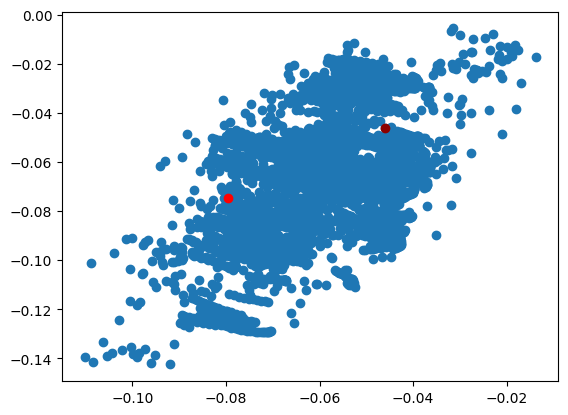

In [22]:
# plot all embeddings in dataset with scatter
plt.scatter(cond_embeddings[:-2,0], cond_embeddings[:-2,1])
plt.scatter(cond_embeddings[-2,0], cond_embeddings[-2,1], c="red")
plt.scatter(cond_embeddings[-1,0], cond_embeddings[-1,1], c="darkred")

## t-SNE visualization of embeddings

In [23]:
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
cond_embeddings_2d = tsne.fit_transform(cond_embeddings)

/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


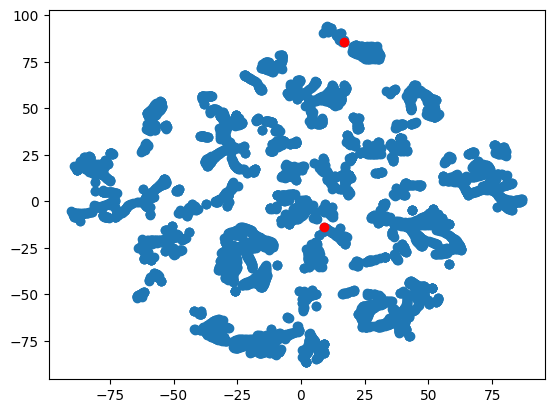

In [24]:
# plot the 2d embeddings
plt.scatter(cond_embeddings_2d[:-2,0], cond_embeddings_2d[:-2,1])
# highlight the obs and G_0
plt.scatter(cond_embeddings_2d[-2,0], cond_embeddings_2d[-2,1], color="red")
plt.scatter(cond_embeddings_2d[-1,0], cond_embeddings_2d[-1,1], color="red")
plt.show()


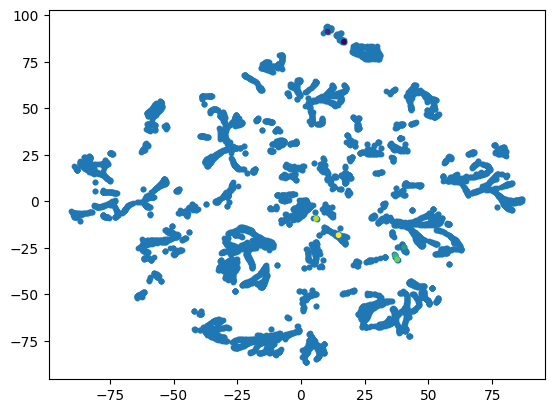

In [25]:
# plot the 2d embeddings with reduced point size
plt.scatter(cond_embeddings_2d[10:,0], cond_embeddings_2d[10:,1], s=10)
# highlight the first 30 embeddings in the dataset (should be in same trajectory)
# with a slightly varying color over time and reduced point size
plt.scatter(cond_embeddings_2d[:10,0], cond_embeddings_2d[:10,1], c=numpy.arange(10), cmap="viridis", s=10)


## Loading pre-trained model

In [17]:
model.load_state_dict(torch.load("../weights/lift_ph_en_graph_diffusion_policy.pt", map_location=model.device))

<All keys matched successfully>

In [18]:
trained_gce=model.cond_encoder

In [19]:
# check difference in embedding space, after condition encoder
obs_cond = trained_gce(obs, G_0.edge_index, G_0.edge_attr)
G_0_cond = trained_gce(G_0.y, G_0.edge_index, G_0.edge_attr)

In [20]:
# calculate distance between obs and G_0
obs_cond = obs_cond.flatten().cpu().detach().numpy()
G_0_cond = G_0_cond.flatten().cpu().detach().numpy()

In [30]:
cond_embeddings = []
times = []
for i in tqdm(range(len(graph_dataset))):
    G = graph_dataset[i]
    cond_embeddings.append(trained_gce(G.y, G.edge_index, G.edge_attr).flatten().cpu().detach().numpy())
    times.append(G.time)

cond_embeddings = numpy.array(cond_embeddings)

  0%|          | 0/6266 [00:00<?, ?it/s]

100%|██████████| 6266/6266 [01:28<00:00, 71.05it/s]


In [32]:
# plot first 30 embeddings in dataset with scatter

# append both obs and G_0 to the list
cond_embeddings = numpy.concatenate([cond_embeddings, [obs_cond, G_0_cond]], axis=0)

### t-SNE visualization of embeddings after training

/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


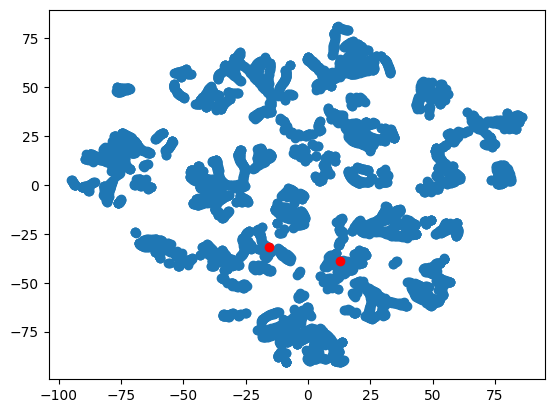

In [33]:
tsne = TSNE(n_components=2, random_state=0)
cond_embeddings_2d = tsne.fit_transform(cond_embeddings)
# plot the 2d embeddings
plt.scatter(cond_embeddings_2d[:-2,0], cond_embeddings_2d[:-2,1])
# highlight the obs and G_0
plt.scatter(cond_embeddings_2d[-2,0], cond_embeddings_2d[-2,1], color="red")
plt.scatter(cond_embeddings_2d[-1,0], cond_embeddings_2d[-1,1], color="red")
plt.show()


In [34]:
tsne = TSNE(n_components=2, random_state=0)
cond_embeddings_2d = tsne.fit_transform(cond_embeddings)

/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/caio/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4186: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


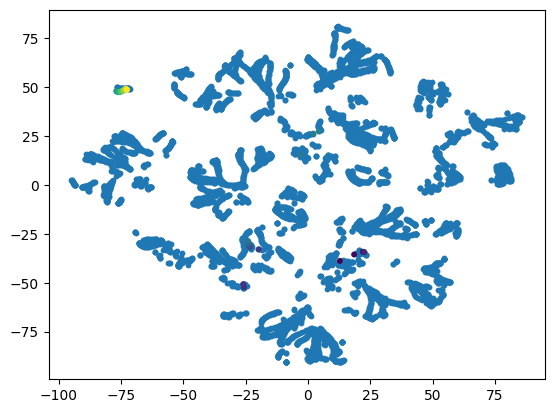

In [35]:
# plot the 2d embeddings with reduced point size
plt.scatter(cond_embeddings_2d[50:,0], cond_embeddings_2d[50:,1], s=10,)
# highlight the first 30 embeddings in the dataset (should be in same trajectory)
# with a slightly varying color over time and reduced point size
plt.scatter(cond_embeddings_2d[:50,0], cond_embeddings_2d[:50,1], c=times[:50], cmap="viridis", s=10)

/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4186: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


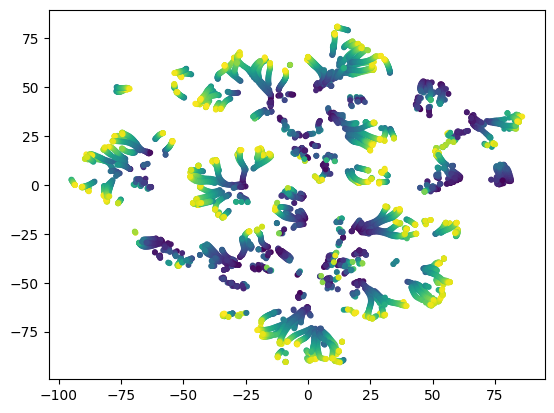

In [39]:
plt.scatter(cond_embeddings_2d[:,0], cond_embeddings_2d[:,1], c=times, cmap="viridis", s=10)

## Explore Translation Variance

How translation variant are the embeddings? Exploring if E_GCN are going to improve the representation.

In [21]:
displaced_G_0 = G_0.clone()

In [22]:
# displaced_G_0.y[:,:,:3]
# Add [0, 0, 0.5] to all positions

displaced_G_0.y[:,:,:3] = displaced_G_0.y[:,:,:3] + torch.tensor([0, 0, 50], dtype=torch.float64)

In [23]:
displaced_G_0.y[:,:,:3]

tensor([[[ 0.0000e+00,  0.0000e+00,  5.0000e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0000e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0000e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0000e+01]],

        [[ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01]],

        [[ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01],
         [ 0.0000e+00,  0.0000e+00,  5.0333e+01]],

        [[ 6.8198e-02, -2.6355e-03,  5.0642e+01],
         [ 7.0870e-02, -2.5882e-03,  5.0641e+01],
         [ 7.5556e-02, -2.5504e-03,  5.0640e+01],
         [ 8.1996e-02, -2.4747e-03,  5.0638e+01]],

        [[ 1.4872e-01, -4.7120e-03,  5.0624e+01],
         [ 1.5124e-01, -4.4365e-03,  5.0622e+01],
         [ 1.5565e-01, -4.0729e-03,  5.0620e+01],
         [ 1.6166e-01, -3.5616e-03,  5.061

In [24]:
# check difference in embedding space, after condition encoder
G_0_cond = trained_gce(G_0.y, G_0.edge_index, G_0.edge_attr)
displaced_G_0_cond = trained_gce(displaced_G_0.y, displaced_G_0.edge_index, displaced_G_0.edge_attr)

In [25]:
G_0_cond - displaced_G_0_cond

tensor([[-24.6431, -21.9362, -28.4324, -24.4427, -20.8598,   6.3007,  34.4189,
         -14.3514,  -4.7590,   7.4698, -10.6653,  22.7429,  -9.2626,   0.2116,
         -17.8365, -22.2277, -40.9276, -63.3152,  30.3175,  12.9862,  -5.3212,
         -11.9433, -33.4570,   7.1836,  45.5391, -50.9654, -16.8720, -22.4261,
           6.8975,   7.6399, -22.8564,   3.2063,  -9.9376, -34.9772, -52.1252,
          40.3974,  -4.5419,  -9.6842, -11.9216,   9.7893,  30.4868,   4.2741,
          11.7136,  -6.0896,  16.9247, -70.5025,  -1.2505,  -4.0141,  -7.9888,
          10.3022, -28.7406,  16.1760,   0.3958, -28.1926,  23.2064,  15.7443,
         -19.3143,  -5.9325,   1.1463,  65.8080,  36.4290,  -8.5888, -31.0008,
          45.0712,  -3.2628,  24.1400, -31.9061,  41.0811, -17.8504, -18.4214,
           6.5608, -58.6881,  24.6577,   5.2730,  15.1772,  -8.7363,  64.7408,
         -16.1172,  35.8573,  52.7474, -28.7399,  15.7273,   1.3445,  51.5128,
          12.9446, -27.9822,  -2.4134,  35.2327,  14

### Using untrained E_GCN

In [43]:
from imitation.model.egnn import EGNN

class EGraphConditionEncoder(nn.Module):
    '''
    Graph Convolutional Network (GCN) for encoding the graph-level conditioning vector
    '''
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers=3, device=None):
        super().__init__()
        if device == None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.graph_encoder = EGNN(
            in_node_nf=input_dim, 
            out_node_nf=hidden_dim,
            hidden_nf=hidden_dim,
            in_edge_nf=1,
            n_layers=n_layers,
            normalize=False).to(self.device)
        self.pool = global_mean_pool
        self.fc = Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x, edge_index, coord, edge_attr):
        x = x.float().to(self.device).flatten(start_dim=1)
        coord = coord.float().to(self.device)
        edge_attr = edge_attr.float().to(self.device).unsqueeze(-1)
        edge_index = edge_index.to(self.device)

        h_v, x = self.graph_encoder(x, coord, edge_index, edge_attr)
        g_v = self.pool(h_v,batch=None)
        h_v = self.fc(g_v)
        return h_v

In [27]:
e_gce = EGraphConditionEncoder(
    input_dim = 4 * model.obs_horizon,
    output_dim = 2,
    hidden_dim = model.hidden_dim,
    device=model.device
)

In [28]:
# check difference in embedding space, after condition encoder
G_0_cond = e_gce(G_0.y[:,:,3:], G_0.edge_index, G_0.y[:,-1,:3], G_0.edge_attr)
displaced_G_0_cond = e_gce(displaced_G_0.y[:,:,3:], displaced_G_0.edge_index, displaced_G_0.y[:,-1,:3], displaced_G_0.edge_attr)

In [29]:
# calculate torch MSE
print(G_0_cond)
print(displaced_G_0_cond)
torch.nn.MSELoss()(G_0_cond, displaced_G_0_cond)

tensor([[-0.1597,  0.0482]], grad_fn=<AddmmBackward0>)
tensor([[-0.1597,  0.0482]], grad_fn=<AddmmBackward0>)


tensor(4.4409e-16, grad_fn=<MseLossBackward0>)

In [30]:
gce = GraphConditionEncoder(
    input_dim = model.cond_feature_dim * model.obs_horizon,
    output_dim = 2,
    hidden_dim = model.hidden_dim,
    device=model.device
)

In [31]:
# check difference in embedding space, after condition encoder
G_0_cond = gce(G_0.y, G_0.edge_index, G_0.edge_attr)
displaced_G_0_cond = gce(displaced_G_0.y, displaced_G_0.edge_index, displaced_G_0.edge_attr)

In [32]:
# calculate torch MSE
print(G_0_cond)
print(displaced_G_0_cond)
torch.nn.MSELoss()(G_0_cond, displaced_G_0_cond)

tensor([[-0.0588,  0.0012]], grad_fn=<AddmmBackward0>)
tensor([[-5.6468,  3.0994]], grad_fn=<AddmmBackward0>)


tensor(20.4121, grad_fn=<MseLossBackward0>)

In [33]:
# Displace only the last node (object) and check the difference in embedding space
displaced_G_0 = G_0.clone()
displaced_G_0.y[-1,:,:3] = displaced_G_0.y[-1,:,:3] + torch.tensor([0, 50, 0], dtype=torch.float64)

In [34]:
G_0_cond = gce(G_0.y, G_0.edge_index, G_0.edge_attr)
displaced_G_0_cond = gce(displaced_G_0.y, displaced_G_0.edge_index, displaced_G_0.edge_attr)
# calculate torch MSE   
print(G_0_cond)
print(displaced_G_0_cond)
torch.nn.MSELoss()(G_0_cond, displaced_G_0_cond)

tensor([[-0.0588,  0.0012]], grad_fn=<AddmmBackward0>)
tensor([[-0.3019,  1.9041]], grad_fn=<AddmmBackward0>)


tensor(1.8399, grad_fn=<MseLossBackward0>)

In [35]:
G_0_cond = e_gce(G_0.y[:,:,3:], G_0.edge_index, G_0.y[:,-1,:3], G_0.edge_attr)
displaced_G_0_cond = e_gce(displaced_G_0.y[:,:,3:], displaced_G_0.edge_index, displaced_G_0.y[:,-1,:3], displaced_G_0.edge_attr)

print(G_0_cond)
print(displaced_G_0_cond)
torch.nn.MSELoss()(G_0_cond, displaced_G_0_cond)

tensor([[-0.1597,  0.0482]], grad_fn=<AddmmBackward0>)
tensor([[-0.6598,  0.1130]], grad_fn=<AddmmBackward0>)


tensor(0.1271, grad_fn=<MseLossBackward0>)

## Comparing to linear encoder

In [36]:
class LinearConditionEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, device=None):
        super().__init__()
        if device == None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.encoder = Linear(input_dim, hidden_dim).to(self.device)
        self.layers = nn.ModuleList()
        for _ in range(2):
            self.layers.append(Linear(hidden_dim, hidden_dim).to(self.device))
        self.pool = global_mean_pool
        self.fc = Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x, edge_index, edge_attr):
        x = x.float().to(self.device).flatten(start_dim=1)
        edge_attr = edge_attr.float().to(self.device)
        edge_index = edge_index.to(self.device)
        h_v = self.encoder(x)
        for layer in self.layers:
            h_v = layer(h_v)
        g_v = self.pool(h_v,batch=None)
        h_v = self.fc(g_v)
        return h_v


In [44]:
lin_gce = LinearConditionEncoder(
    input_dim = model.cond_feature_dim * model.obs_horizon,
    output_dim = 2,
    hidden_dim = model.hidden_dim,
    device=model.device
)
e_gce = EGraphConditionEncoder(
    input_dim = 4 * model.obs_horizon,
    output_dim = 2,
    hidden_dim = model.hidden_dim,
    n_layers=5,
    device=model.device
)

In [38]:
# plot all embeddings in dataset with scatter
cond_embeddings = []
times = []
for i in tqdm(range(len(graph_dataset))):
    G = graph_dataset[i]
    cond_embeddings.append(lin_gce(G.y, G.edge_index, G.edge_attr).flatten().cpu().detach().numpy())
    times.append(G.time)
    
cond_embeddings = numpy.array(cond_embeddings)

  0%|          | 0/6266 [00:00<?, ?it/s]

100%|██████████| 6266/6266 [01:27<00:00, 71.25it/s]


/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4186: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


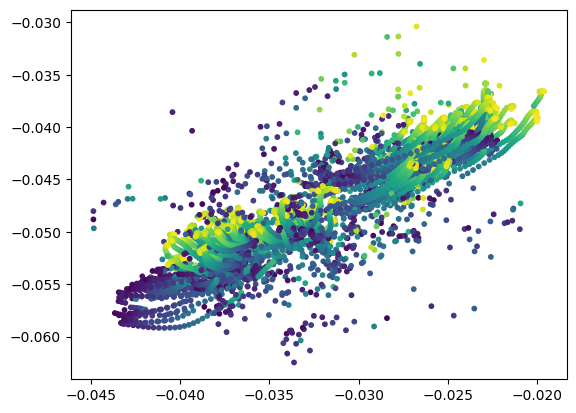

In [40]:
plt.scatter(cond_embeddings[:,0], cond_embeddings[:,1], c=times, cmap="viridis", s=10)

  0%|          | 0/6266 [00:00<?, ?it/s]

100%|██████████| 6266/6266 [01:23<00:00, 74.65it/s]
/home/caio/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4186: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


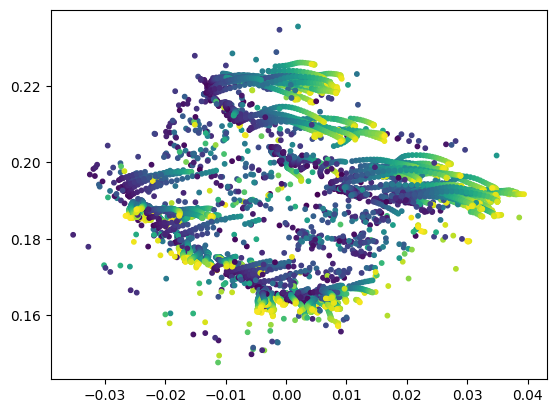

In [45]:
# plot all embeddings in dataset with scatter for (untrained) equivariant GCE
cond_embeddings = []
times = []
for i in tqdm(range(len(graph_dataset))):
    G = graph_dataset[i]
    cond_embeddings.append(e_gce(G.y[:,:,3:], G.edge_index,  G_0.y[:,-1,:3], G.edge_attr).flatten().cpu().detach().numpy())
    times.append(G.time)
    
cond_embeddings = numpy.array(cond_embeddings)
plt.scatter(cond_embeddings[:,0], cond_embeddings[:,1], c=times, cmap="viridis", s=10)

## Adapting reparametrization trick

Try and get a smoother distribution of the embeddings.

In [47]:
class EGraphConditionEncoder(nn.Module):
    '''
    Graph Convolutional Network (GCN) for encoding the graph-level conditioning vector
    '''
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers=3, device=None):
        super().__init__()
        if device == None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.graph_encoder = EGNN(
            in_node_nf=input_dim, 
            out_node_nf=hidden_dim,
            hidden_nf=hidden_dim,
            in_edge_nf=1,
            n_layers=n_layers,
            normalize=False).to(self.device)
        self.pool = global_mean_pool
        self.fc = Linear(hidden_dim, 2 * output_dim).to(self.device)

    def reparameterize(self, mu, var):
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, edge_index, coord, edge_attr):
        x = x.float().to(self.device).flatten(start_dim=1)
        coord = coord.float().to(self.device)
        edge_attr = edge_attr.float().to(self.device).unsqueeze(-1)
        edge_index = edge_index.to(self.device)

        h_v, x = self.graph_encoder(x, coord, edge_index, edge_attr)
        g_v = self.pool(h_v,batch=None)
        h_v = self.fc(g_v)
        h_v_mean = h_v[:,:self.output_dim]
        h_v_var = h_v[:,self.output_dim:]
        h_v = self.reparameterize(h_v_mean, h_v_var)
        return h_v, h_v_mean, h_v_var